In [551]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import compute_rsquared
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [552]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [553]:
data, all_gdps, all_gts = load_data()

In [554]:
all_gdps['country'].unique()

array(['Switzerland', 'United Kingdom', 'Korea', 'Japan', 'United States',
       'Canada', 'Germany'], dtype=object)

In [555]:
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

Data shape : (502, 191)
         date      country  Expense_average_1y_diff  Expense_average_2y_diff  \
0  2006-03-01  Switzerland                 3.988984                 4.615121   

        GDP  
0  0.098917  


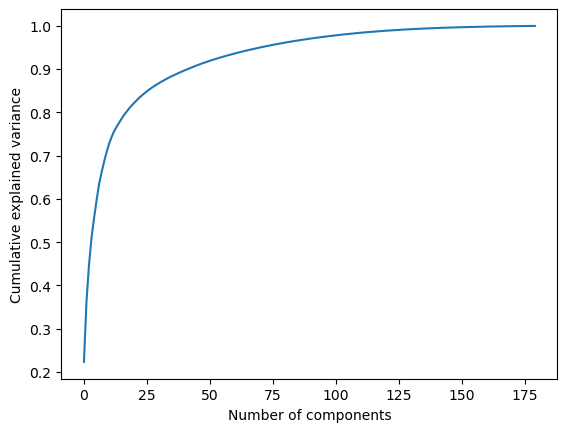

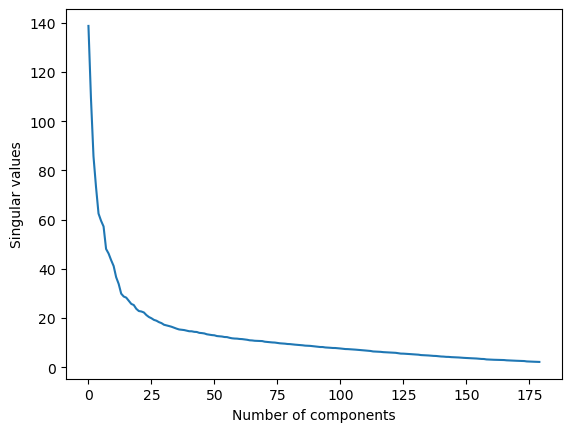

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


In [556]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, _ = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE, 
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': True})



In [557]:
all_gts['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [558]:
y_train[-10:]

array([2.80287438, 1.68349853, 2.08976164, 2.52454794, 1.49322908,
       0.24314821, 0.64567929, 2.93133928, 2.3807998 , 1.82913417])

## Simple Prediction Model

### We start with a simple regression model

In [559]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [560]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, verbose = True):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())
    print(f"Validation loss: {v_loss.item()}")

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())
    print(f"Training loss: {t_loss.item()}")

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)
    print(f"Validation R^2: {r_squared}")
    
    return model, training_loss, validation_loss, valid_r_squared

In [579]:
model, training_loss, validation_loss, validation_r_squared = train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=5e-4, weight_decay=7e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss: 0.5733916163444519
Training loss: 0.14877717196941376
Validation R^2: 0.2597273545990948


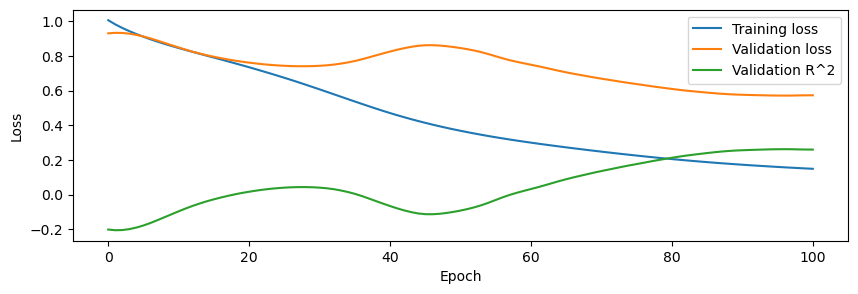

In [580]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.plot(validation_r_squared, label="Validation R^2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xlim(0, 50)
plt.show()


In [581]:
# Make bootrapping
n_bootstrap = 100
n = len(X_train)
n_features = X_train.shape[1]

n_countries = len(np.unique(preprocessor.country_train))

bootstrap_size =  np.ceil(200 / n_countries).astype(int) # n // n_countries #

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)
rsquared_bootstrap = np.zeros(n_bootstrap)

for i in tqdm(range(n_bootstrap)):
    # Make a bootstrap sample of size bootstrap_size
    set_seed(SEED + i)

    indices_per_country = [np.where(preprocessor.country_train == c)[0] for c in np.unique(preprocessor.country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = X_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, X_valid, y_valid, num_epochs=100, learning_rate=5e-4, weight_decay=7e-2, verbose=False)
    y_pred = model_bootstrap(torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

    mse = mean_squared_error(y_valid, y_pred)
    rsquared = compute_rsquared(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse
    rsquared_bootstrap[i] = rsquared

# Aggregate the predictions
y_pred = np.zeros((X_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

# Get the model with the best R squared
best_model_idx = np.argmax(rsquared_bootstrap)
best_model = bootstrap_models[best_model_idx]
best_rsquared = rsquared_bootstrap[best_model_idx]
y_pred_best = best_model(torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss: 1.2904959917068481
Training loss: 0.04736099764704704
Validation R^2: -0.6660845021534936
Validation loss: 0.609486997127533
Training loss: 0.03687727078795433
Validation R^2: 0.2131267301466746
Validation loss: 0.5530781745910645
Training loss: 0.07653862237930298
Validation R^2: 0.28595284401669874
Validation loss: 1.0821795463562012
Training loss: 0.05557448789477348
Validation R^2: -0.39713916811726735
Validation loss: 0.8640565872192383
Training loss: 0.05231333523988724
Validation R^2: -0.11553333881925543
Validation loss: 0.7598763108253479
Training loss: 0.04652518779039383
Validation R^2: 0.01896772351309617
Validation loss: 0.8096601366996765
Training loss: 0.04987616091966629
Validation R^2: -0.04530525136991437
Validation loss: 1.8272428512573242
Training loss: 0.052134133875370026
Validation R^2: -1.3590474818761829
Validation loss: 0.5223932862281799
Training loss: 0.04722323641180992
Validation R^2: 0.32556837223333646
Validation loss: 0.7841716408729553

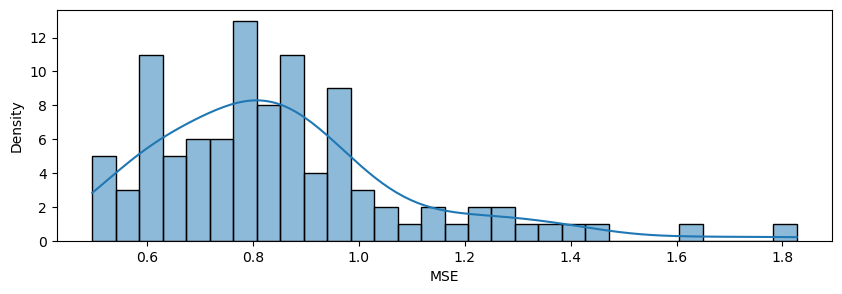

In [582]:
# Plot the MSE
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

Bootstrapped R^2: 0.24834720440525015
Bootstrapped MSE: 0.5822063010581843
Bootstrapped MAPE: 107.79029643036246


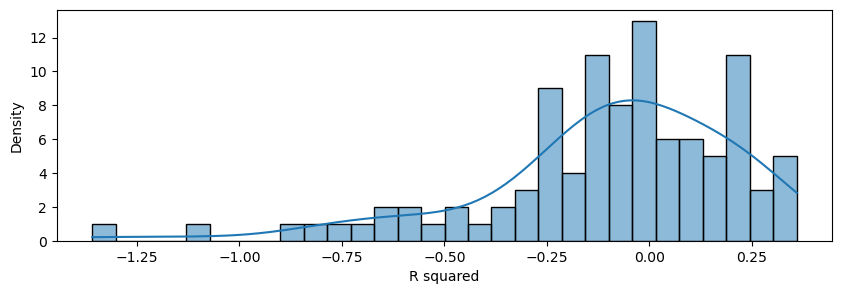

In [583]:
# Plot the r squared
bootstrapped_r2 = compute_rsquared(y_valid, y_pred_mean)
bootstrapped_mse = mean_squared_error(y_valid, y_pred_mean)
bootstrapped_mape = np.mean(np.abs((y_valid - y_pred_mean) / y_valid)) * 100
print(f"Bootstrapped R^2: {bootstrapped_r2}")
print(f"Bootstrapped MSE: {bootstrapped_mse}")
print(f"Bootstrapped MAPE: {bootstrapped_mape}")

plt.figure(figsize=(10, 3))
sns.histplot(rsquared_bootstrap, bins=30, kde=True)
plt.xlabel("R squared")
plt.ylabel("Density")
plt.show()

In [584]:
# Plot the predictions per country, per date
def plot_by_country(selected_country, country_valid):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.plot(y_pred_best[country_valid == selected_country], label="Predicted (best)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 3 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 3 * y_pred_std[country_valid == selected_country], alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 1.96 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 1.96 * y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(preprocessor.country_valid), country_valid=widgets.fixed(preprocessor.country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country, country_valid)>

In [585]:
# THIS IS BASED ONLY ON THE FIRST MODEL !! NOT THE BOOTSTRAP MODELS

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [586]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [587]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [589]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…